In [1]:
import shutil

import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import warnings
import os

from functions import *

pd.set_option('display.float_format', '{:.6f}'.format)

2023-09-27 17:13:13.017614: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 17:13:13.588521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data

In [2]:
df = pd.read_csv(df_path, index_col="Unnamed: 0").T

In [3]:
print(df)

              1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8         0        0        0        0        0        0        0   
E000823.2.6         0        0        0        0        0        0        0   
E000823.4.0         0        0        0        0        0        0        0   
E000823.5.0         0        0        0        0        0        0        0   
E000823.5.7         0        0        0        0        0        0        0   
...               ...      ...      ...      ...      ...      ...      ...   
E014086.30.4        0        0        0        0        0        1       11   
E014086.32.4        0        0        0        0        0        0       13   
E014086.33.5        0        0        0        0        0        0        0   
E014086.34.4        0        0        0        0        0        1        0   
E014086.36.0        0        0        0        0        0        0        0   

              4327628  326749   183857   ...  31792

## Preprocessing


In [4]:
zero_values_percentage_cutoff = 0.5 # no more than x% of data can be zeros
smoothing_window_size = 5
df = preprocess(zero_values_percentage_cutoff=zero_values_percentage_cutoff, smoothing_window_size=smoothing_window_size)

2023-09-27 17:13:19.972069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 17:13:19.998338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 17:13:20.002779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 17:13:20.029640: I tensorflow/core/platform/cpu_featu

In [5]:
df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
E000823.1.8,0.000000,0.000221,0.195402,0.002871,0.000000,0.252560,0.009901,0.145455,0.000000,0.087963,...,0.000000,0.237179,0.000433,0.102041,0.000000,0.042448,0.507874,0.063005,0.010525,0.043189
E000823.2.6,0.052888,0.000273,0.137931,0.012440,0.000000,0.204778,0.007921,0.109091,0.000000,0.120370,...,0.000000,0.173077,0.000939,0.163265,0.000067,0.037373,0.437008,0.056729,0.010298,0.019934
E000823.4.0,0.052888,0.000256,0.160920,0.013397,0.000000,0.443686,0.019802,0.072727,0.000000,0.074074,...,0.000000,0.179487,0.000987,0.183673,0.000067,0.053983,0.389764,0.069040,0.032819,0.013289
E000823.5.0,0.052888,0.000204,0.103448,0.053589,0.000000,0.375427,0.019802,0.054545,0.000000,0.064815,...,0.000000,0.166667,0.003901,0.183673,0.000089,0.048139,0.338583,0.052505,0.030623,0.000000
E000823.5.7,0.052888,0.000204,0.195402,0.053589,0.046985,0.382253,0.021782,0.054545,0.112668,0.078704,...,0.000000,0.147436,0.080911,0.122449,0.053025,0.044909,0.287402,0.054919,0.083269,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
E014086.23.4,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
E014086.24.5,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
E014086.26.4,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


## Features and targets

In [6]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = cut_to_sequences(feats_df=df, seq_length=seq_length)

y_targets = pd.DataFrame(y_targets)
y_targets.columns = df.columns

X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 466
Train sequences: 411
Test sequences: 55


In [7]:
y_targets

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.006383,0.000119,0.172414,0.003349,0.000000,0.105802,0.019802,0.181818,0.025556,0.129630,...,0.022838,0.160256,0.000241,0.346939,0.001832,0.037066,0.181102,0.036934,0.062740,0.305648
1,0.000304,0.000085,0.137931,0.004306,0.000000,0.109215,0.009901,0.218182,0.000000,0.120370,...,0.000000,0.160256,0.000265,0.326531,0.000045,0.031221,0.196850,0.035607,0.089471,0.212625
2,0.000304,0.000307,0.149425,0.007177,0.000000,0.116041,0.001980,0.272727,0.000000,0.148148,...,0.000000,0.141026,0.000241,0.326531,0.000022,0.025377,0.161417,0.028485,0.087275,0.212625
3,0.000304,0.000290,0.126437,0.007656,0.000000,0.095563,0.000000,0.181818,0.000000,0.134259,...,0.000000,0.076923,0.000265,0.265306,0.000022,0.014611,0.102362,0.018829,0.067131,0.209302
4,0.000304,0.000290,0.114943,0.018182,0.000000,0.116041,0.003960,0.181818,0.000000,0.111111,...,0.000000,0.089744,0.000843,0.244898,0.000000,0.016764,0.110236,0.025106,0.049771,0.199336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0.054103,0.115345,0.172414,0.001435,0.058205,0.044369,0.033663,0.418182,0.361913,0.402778,...,0.339315,0.115385,0.000024,0.428571,0.045208,0.085205,0.177165,0.131201,0.328075,0.289037
462,0.084802,0.145123,0.183908,0.006699,0.062412,0.088737,0.035644,0.545455,0.462215,0.532407,...,0.428222,0.115385,0.000747,0.489796,0.061491,0.110889,0.212598,0.174412,0.407474,0.209302
463,0.094833,0.161664,0.379310,0.009091,0.105189,0.143345,0.067327,0.563636,0.874141,0.800926,...,0.644372,0.205128,0.000747,0.489796,0.084206,0.133959,0.283465,0.297284,0.596487,0.325581
464,0.059574,0.153453,0.597701,0.009091,0.183029,0.334471,0.071287,0.709091,0.932949,0.828704,...,0.712072,0.243590,0.000747,0.408163,0.071408,0.196555,0.334646,0.417139,0.741297,0.365449


## The model

In [55]:
def fetch_model():

    loss="mae"
    
    n_feats = len(df.columns)
    
    model = Sequential()
    model.add(keras.Input(shape=(seq_length, n_feats)))
    model.add(keras.layers.LSTM(512, return_sequences=False, activation='relu'))
    model.add(keras.layers.Dense(256, activation="tanh"))
    model.add(keras.layers.Dense(128, activation="tanh"))
    model.add(keras.layers.Dense(1, activation="relu"))
    
    model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])
    
    return model

In [52]:
#model = fetch_model()
#
#model.summary()
#
#model.save("/home/nate/temp/test_model_save.model")

## Individual model testbench

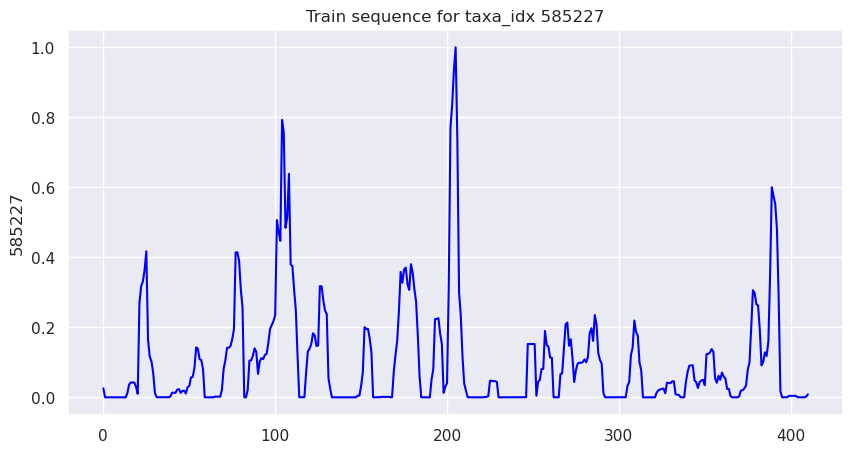

In [53]:
target_taxa = 585227
n_epochs = 10


plot_a_taxa_sequence(y_targets_train[target_taxa], title=f"Train sequence for taxa_idx {target_taxa}", color="blue")

In [54]:
model = fetch_model()

model.fit(x=X_sequences_train, y=y_targets_train[target_taxa], validation_split=0.05, epochs=n_epochs, verbose=1)

Epoch 1/10
13/13 [==============================] - 2s 44ms/step - loss: 0.1884 - mae: 0.1884 - mape: 14648589.0000 - val_loss: 0.0922 - val_mae: 0.0922 - val_mape: 80.9524
Epoch 2/10
13/13 [==============================] - 0s 34ms/step - loss: 0.1043 - mae: 0.1043 - mape: 75.8974 - val_loss: 0.0922 - val_mae: 0.0922 - val_mape: 80.9524
Epoch 3/10
13/13 [==============================] - 0s 33ms/step - loss: 0.1043 - mae: 0.1043 - mape: 75.8974 - val_loss: 0.0922 - val_mae: 0.0922 - val_mape: 80.9524
Epoch 4/10
13/13 [==============================] - 0s 33ms/step - loss: 0.1043 - mae: 0.1043 - mape: 75.8974 - val_loss: 0.0922 - val_mae: 0.0922 - val_mape: 80.9524
Epoch 5/10
13/13 [==============================] - 0s 33ms/step - loss: 0.1043 - mae: 0.1043 - mape: 75.8974 - val_loss: 0.0922 - val_mae: 0.0922 - val_mape: 80.9524
Epoch 6/10
13/13 [==============================] - 0s 34ms/step - loss: 0.1043 - mae: 0.1043 - mape: 75.8974 - val_loss: 0.0922 - val_mae: 0.0922 - val_mape: 

2/2 [==============================] - 0s 7ms/step


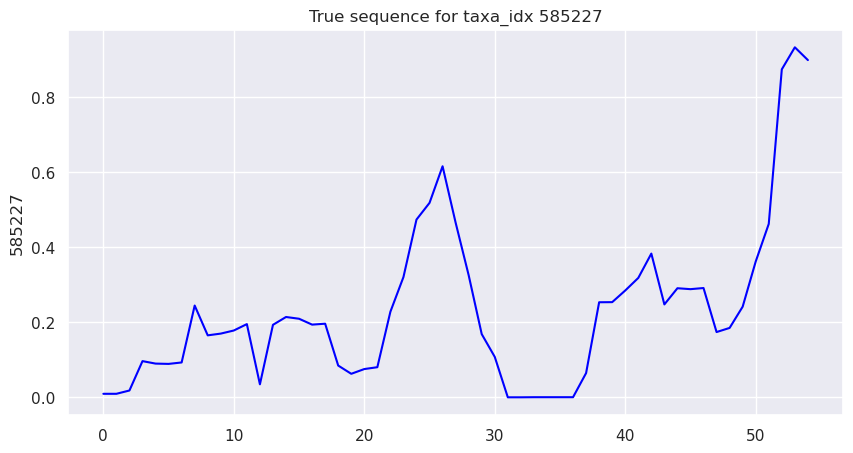

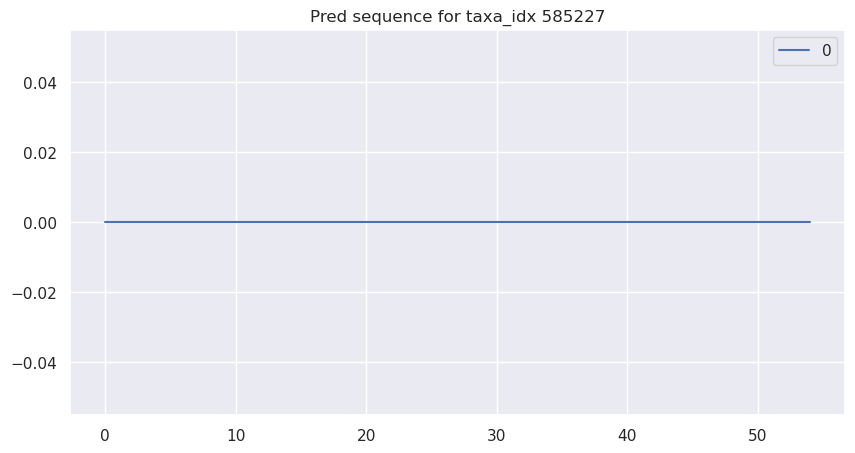

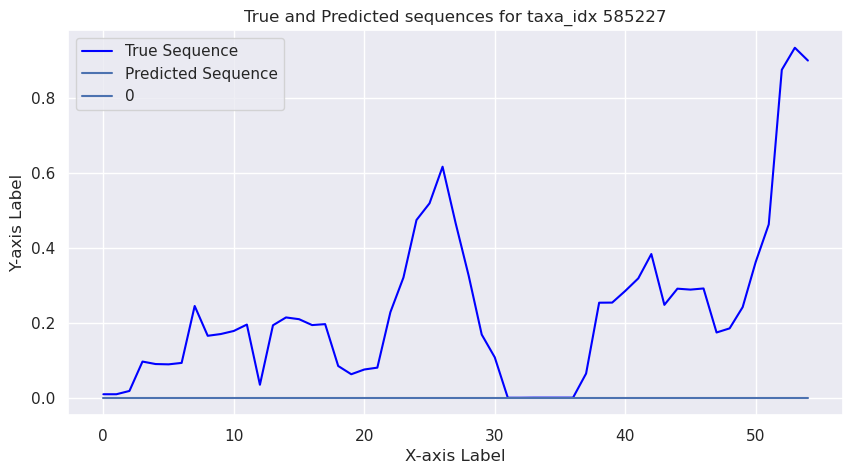

In [42]:
y_pred = model.predict(X_sequences_test)

true_sequence = y_targets_test[target_taxa].reset_index(drop=True)
pred_sequence = y_pred

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

## The Ensemble

In [56]:
class ensemble():
    
    def __init__(self, ensemble_name, overwrite_on_train=False):
        
        self.models_out_dir = f"{root_dir}/models/{ensemble_name}"
        self.overwrite_on_train = overwrite_on_train

        
    def train(self, X_sequences_train, y_targets_train, n_epochs):
        
        if not os.path.exists(self.models_out_dir):
            os.mkdir(self.models_out_dir)
        else:
            if self.overwrite_on_train is False:
                raise Exception("This model dir already exists")
            else:
                print("Overwriting an existing model dir")
                shutil.rmtree(self.models_out_dir)
                os.mkdir(self.models_out_dir)
                
        for taxa_idx in tqdm(y_targets_train.columns, desc="Training models"):
            
            model = fetch_model()
            y_targets = y_targets_train[taxa_idx]
            model.fit(x=X_sequences_train, y=y_targets, validation_split=0.05, epochs=n_epochs, verbose=0)
            
            model.save(f"{self.models_out_dir}/{taxa_idx}.model")
            
            del model
            
    
    def load(self):
        
        self.model_dic = {}
        
        for model_dir in tqdm(os.listdir(self.models_out_dir), desc="Loading the models"):
            taxa_idx = int(model_dir.replace(".model", ""))
            model = tf.keras.models.load_model(f"{self.models_out_dir}/{taxa_idx}.model")
            self.model_dic[taxa_idx] = model
    
         
    def predict(self, X_sequences):
        
        self.load()
        
        n_sequences = len(X_sequences)
        
        pred_df = [pd.DataFrame()]
        for taxa_idx in self.model_dic.keys():
            model = self.model_dic[taxa_idx]
            pred_df[taxa_idx] = model.predict(X_sequences).reshape(n_sequences,)
            del(model)
            
        return pred_df

In [57]:
# Tensorflow does not play nice with my Linux machine, thus I am filtering out its warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

model_ensemble = ensemble(ensemble_name="test_ensemble", overwrite_on_train=True)

In [58]:
model_ensemble.train(X_sequences_train=X_sequences_train, y_targets_train=y_targets_train, n_epochs=15)

Overwriting an existing model dir


Training models: 100%|██████████| 202/202 [30:35<00:00,  9.09s/it]


In [60]:
model_ensemble.load()

Loading the models: 100%|██████████| 202/202 [01:38<00:00,  2.06it/s]


In [62]:
self = model_ensemble

n_sequences = len(X_sequences)

pred_list = []
for taxa_idx in tqdm(self.model_dic.keys(), desc="Predicting values"):
    model = self.model_dic[taxa_idx]
    pred_list.append(model.predict(X_sequences, verbose=0).reshape(n_sequences,))

Predicting values: 100%|██████████| 202/202 [00:49<00:00,  4.07it/s]


In [65]:
pred_list

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [68]:
pd.DataFrame(y_targets_test)

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
411,0.037386,0.013270,0.436782,0.017225,0.147265,0.109215,0.615842,0.254545,0.009343,0.046296,...,0.268352,0.153846,0.021143,0.163265,0.053025,0.587819,0.082677,0.266264,0.265606,0.302326
412,0.019149,0.012742,0.344828,0.014833,0.117812,0.054608,0.483168,0.254545,0.009343,0.046296,...,0.238989,0.083333,0.021143,0.163265,0.040316,0.453091,0.062992,0.202535,0.222715,0.235880
413,0.012158,0.014207,0.264368,0.014354,0.112202,0.058020,0.843564,0.254545,0.018137,0.101852,...,0.196574,0.070513,0.020396,0.142857,0.076992,0.786066,0.055118,0.393724,0.255036,0.481728
414,0.008207,0.010511,0.103448,0.008134,0.069425,0.040956,0.506931,0.072727,0.096455,0.074074,...,0.079119,0.032051,0.018687,0.061224,0.062362,0.582744,0.055118,0.300905,0.142139,0.385382
415,0.008207,0.004054,0.057471,0.006699,0.062412,0.037543,0.435644,0.018182,0.089860,0.078704,...,0.061990,0.032051,0.050690,0.040816,0.058386,0.470624,0.059055,0.257333,0.089946,0.338870
416,0.001520,0.004940,0.137931,0.003349,0.012623,0.098976,0.475248,0.000000,0.089035,0.078704,...,0.013051,0.121795,0.128928,0.040816,0.056085,0.616887,0.192913,0.305854,0.089652,0.335548
417,0.001520,0.007478,0.137931,0.006220,0.012623,0.109215,0.487129,0.000000,0.092883,0.078704,...,0.013051,0.134615,0.147687,0.040816,0.056085,0.653491,0.212598,0.324321,0.100833,0.335548
418,0.000608,0.006712,0.091954,0.008612,0.011921,0.112628,0.077228,0.000000,0.244573,0.013889,...,0.004894,0.179487,0.172972,0.020408,0.004221,0.257767,0.204724,0.107423,0.037753,0.049834
419,0.000000,0.006184,0.114943,0.008134,0.011921,0.129693,0.073267,0.000000,0.165155,0.004630,...,0.000816,0.185897,0.173140,0.000000,0.000424,0.246386,0.200787,0.107906,0.070708,0.003322
420,0.000000,0.006490,0.229885,0.016268,0.080645,0.133106,0.089109,0.000000,0.169827,0.000000,...,0.267537,0.160256,0.132155,0.000000,0.009225,0.261150,0.200787,0.126735,0.127246,0.000000


In [69]:
pd.DataFrame(pred_list).T

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [61]:
y_pred_df = model_ensemble.predict(X_sequences_test)

Loading the models: 100%|██████████| 202/202 [01:51<00:00,  1.81it/s]

2/2 [==============================] - 0s 7ms/step


IndexError: list assignment index out of range

In [20]:
y_test_df = pd.DataFrame(y_targets_test)
y_test_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
411,0.037386,0.013270,0.436782,0.017225,0.147265,0.109215,0.615842,0.254545,0.009343,0.046296,...,0.268352,0.153846,0.021143,0.163265,0.053025,0.587819,0.082677,0.266264,0.265606,0.302326
412,0.019149,0.012742,0.344828,0.014833,0.117812,0.054608,0.483168,0.254545,0.009343,0.046296,...,0.238989,0.083333,0.021143,0.163265,0.040316,0.453091,0.062992,0.202535,0.222715,0.235880
413,0.012158,0.014207,0.264368,0.014354,0.112202,0.058020,0.843564,0.254545,0.018137,0.101852,...,0.196574,0.070513,0.020396,0.142857,0.076992,0.786066,0.055118,0.393724,0.255036,0.481728
414,0.008207,0.010511,0.103448,0.008134,0.069425,0.040956,0.506931,0.072727,0.096455,0.074074,...,0.079119,0.032051,0.018687,0.061224,0.062362,0.582744,0.055118,0.300905,0.142139,0.385382
415,0.008207,0.004054,0.057471,0.006699,0.062412,0.037543,0.435644,0.018182,0.089860,0.078704,...,0.061990,0.032051,0.050690,0.040816,0.058386,0.470624,0.059055,0.257333,0.089946,0.338870
416,0.001520,0.004940,0.137931,0.003349,0.012623,0.098976,0.475248,0.000000,0.089035,0.078704,...,0.013051,0.121795,0.128928,0.040816,0.056085,0.616887,0.192913,0.305854,0.089652,0.335548
417,0.001520,0.007478,0.137931,0.006220,0.012623,0.109215,0.487129,0.000000,0.092883,0.078704,...,0.013051,0.134615,0.147687,0.040816,0.056085,0.653491,0.212598,0.324321,0.100833,0.335548
418,0.000608,0.006712,0.091954,0.008612,0.011921,0.112628,0.077228,0.000000,0.244573,0.013889,...,0.004894,0.179487,0.172972,0.020408,0.004221,0.257767,0.204724,0.107423,0.037753,0.049834
419,0.000000,0.006184,0.114943,0.008134,0.011921,0.129693,0.073267,0.000000,0.165155,0.004630,...,0.000816,0.185897,0.173140,0.000000,0.000424,0.246386,0.200787,0.107906,0.070708,0.003322
420,0.000000,0.006490,0.229885,0.016268,0.080645,0.133106,0.089109,0.000000,0.169827,0.000000,...,0.267537,0.160256,0.132155,0.000000,0.009225,0.261150,0.200787,0.126735,0.127246,0.000000


In [21]:
y_pred_df

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.226886,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.131962,0.000000,0.336319,0.038036,0.243486,0.000000,0.229347
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.234757,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.122736,0.000000,0.313622,0.029594,0.228112,0.000000,0.247895
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.219258,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.119565,0.000000,0.258774,0.022488,0.192414,0.000000,0.248475
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211247,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.118783,0.000000,0.360515,0.017718,0.257572,0.000000,0.242869
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.167872,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.109122,0.000000,0.335140,0.022902,0.238169,0.000000,0.215288
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141592,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.111044,0.000000,0.270769,0.023916,0.190427,0.000000,0.196563
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103412,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.108792,0.000000,0.289215,0.067390,0.181742,0.000000,0.144431
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.088513,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.095601,0.000000,0.294508,0.126801,0.174317,0.000000,0.104523
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057567,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.067241,0.000000,0.172072,0.193934,0.113956,0.000000,0.053643
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037533,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.046103,0.000000,0.120780,0.223670,0.089730,0.000000,0.021475


In [29]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 134, 66.33663366336634% of all taxa


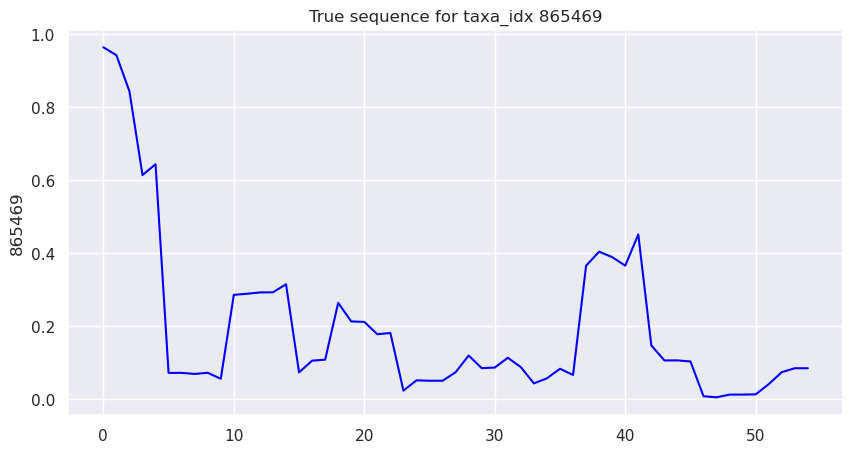

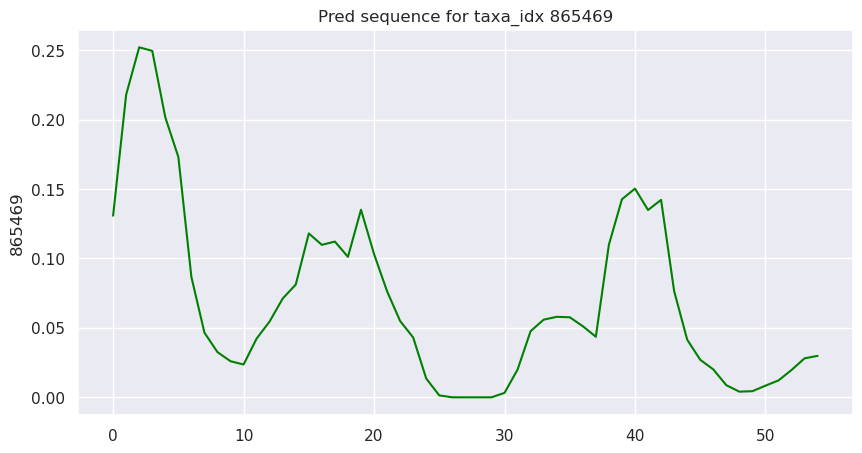

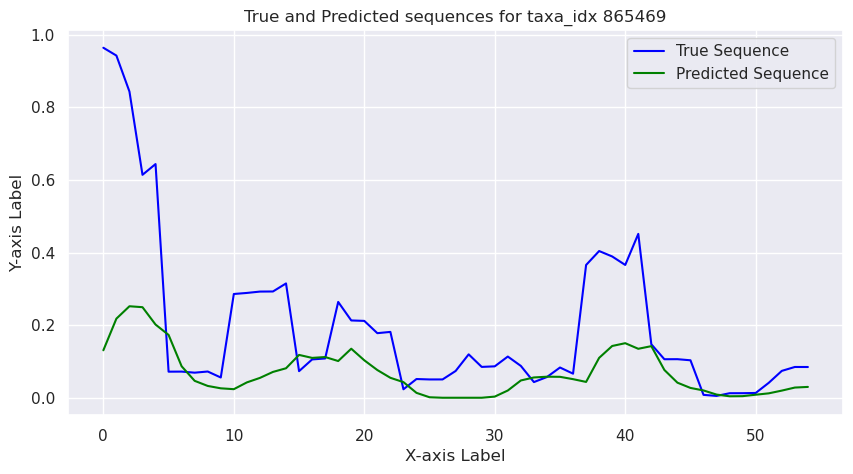

In [30]:
target_taxa = 865469

true_sequence = y_test_df[target_taxa].reset_index(drop=True)
pred_sequence = y_pred_df[target_taxa]

sequence_comparisson_graphs(true_sequence, pred_sequence, target_taxa)

In [31]:
def calculate_percentage_errors(y_pred_df, y_test_df):
    # Description: calculate percentage errors on on all taxa

    y_pred_df = y_pred_df.reset_index(drop=True)
    y_test_df = y_test_df.reset_index(drop=True)

    errors_df = []
    for col in y_pred_df.columns:
        errors = abs((y_pred_df[col] - y_test_df[col]) / (y_pred_df[col] + 1e-10))
        errors_df.append(errors)

    errors_df = pd.concat(errors_df, axis=1)

    return errors_df

In [32]:
errors_df = calculate_percentage_errors(y_pred_df, y_test_df)
errors_df.describe()

,659361,364179,3439402,181155,302746,4473763,175535,3887769,585227,189384,...,359650,130663,922761,3304236,584137,193233,4334711,196664,583117,354850
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,218900245.764851,2249847427.535937,1596656196.028226,119356240.250703,704449818.466574,837108273.030666,1825022477.883562,0.597311,2314971614.648786,1962121185.924084,...,2479756751.705578,670163161.215532,275645414.306284,0.487632,517579351.481066,0.618313,16463852.238909,0.657324,1719474382.497677,0.726615
std,314236370.956718,2965623042.675204,1361038444.567249,83268344.397100,536075165.702982,847480332.159651,2293944648.700401,0.485806,2183716957.544773,1904775511.030745,...,1955578473.658811,605599701.109030,439008988.533403,0.356840,424151646.516404,0.488306,122099185.874699,0.462549,1561095784.211890,0.529178
min,0.000000,40543762.873899,0.000000,9569377.862666,63113603.645422,0.000000,0.000000,0.009841,0.000000,0.000000,...,0.000000,0.000000,240807.182471,0.004483,223358.867715,0.014507,0.000000,0.013252,226336.514112,0.032698
25%,4559270.455845,160386356.074687,747126426.806401,57416267.175994,217391301.445341,221843000.451048,346534648.838613,0.243556,824402297.319512,787037026.528966,...,770799337.180177,224358971.363461,16134081.225577,0.208889,141497842.697699,0.347779,0.165216,0.218138,815603628.601719,0.345376
50%,12158054.548919,1148512812.167328,1264367799.210834,95693778.626657,624123413.826946,716723539.918769,693069297.677226,0.548288,1937345398.700854,1388888870.345233,...,2210440427.257439,512820505.973625,41418835.385064,0.456525,452078348.255947,0.431872,0.626543,0.627630,1450590718.942255,0.586790
75%,405775070.570164,2916510471.775547,2068965489.617728,153110045.802652,1118513309.049416,1126279848.443780,3851485097.092010,0.914865,2910140109.537878,2245370340.391461,...,3968189180.297949,993589730.323898,402750012.683250,0.682722,784771381.718019,0.901440,1.487220,0.984269,2064981186.498622,0.996720
max,948328254.815663,9999999866.485682,6091953941.652198,368421047.712630,1830294505.717225,4744027240.414709,8435643451.728517,2.967152,9329485997.999146,8287036926.393227,...,7120717686.331159,2435897403.374717,1731403641.968648,1.766269,1445355232.986282,2.617051,905511798.933743,1.828479,7504187125.375329,2.254040


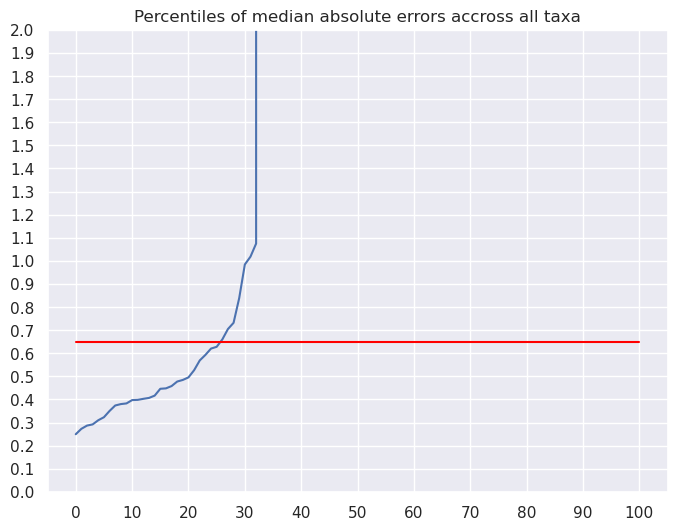

In [33]:
percentile_graph(errors_df, "accross all taxa", y_top_lim=2, x_percentile=0.65)

In [34]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]
only_predicted_errors.describe()

,3887769,865469,4339832,4345850,682726,844375,509416,194236,196518,4361727,...,301578,4357811,586290,4419650,177567,3304236,193233,4334711,196664,354850
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.597311,59775960.765743,0.930608,0.567737,1.188683,0.495856,1.961085,31310079.982221,0.526332,0.387096,...,0.516760,0.344980,418354160.937379,57082455.123205,62695924.825674,0.487632,0.618313,16463852.238909,0.657324,0.726615
std,0.485806,225829127.828739,1.054860,0.677022,0.835100,0.322472,9.744859,134226698.130971,0.395208,0.290105,...,0.341228,0.279592,1755427970.025130,247802192.737104,218198229.030234,0.356840,0.488306,122099185.874699,0.462549,0.529178
min,0.009841,0.014871,0.035525,0.012430,0.014263,0.012166,0.001309,0.010314,0.000000,0.007233,...,0.010972,0.020375,0.000000,0.075684,0.000000,0.004483,0.014507,0.000000,0.013252,0.032698
25%,0.243556,0.574805,0.340330,0.193200,0.559364,0.189459,0.301313,0.164726,0.204135,0.146240,...,0.241869,0.128263,0.342173,0.454918,0.153236,0.208889,0.347779,0.165216,0.218138,0.345376
50%,0.548288,1.837679,0.688894,0.313494,1.058017,0.402161,0.479742,0.463362,0.476803,0.334797,...,0.447216,0.281481,1.109263,1.058255,0.818381,0.456525,0.431872,0.626543,0.627630,0.586790
75%,0.914865,2.995901,1.000000,0.704860,1.794755,0.810148,0.708626,1.072477,0.885350,0.516668,...,0.688602,0.460276,48.801605,1.804410,1.712452,0.682722,0.901440,1.487220,0.984269,0.996720
max,2.967152,1195734581.191629,6.522400,4.275058,3.669638,1.066049,72.690463,725075519.020110,1.656829,1.000000,...,1.217485,1.000000,9436018831.361609,1395348818.579397,965517228.488273,1.766269,2.617051,905511798.933743,1.828479,2.254040


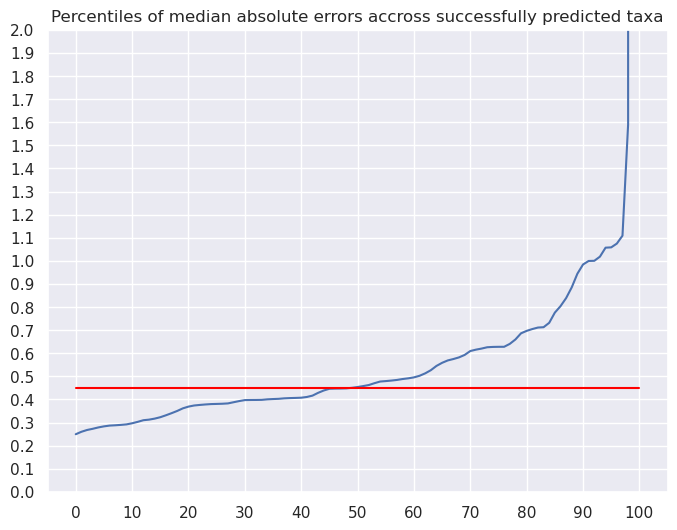

In [36]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", y_top_lim=2, x_percentile=0.45)